In [2]:
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense,Flatten,GlobalAveragePooling2D,Input,Lambda
from tensorflow.keras.models import Model,load_model
import tensorflow.keras.backend as K
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score,confusion_matrix
from skimage.color import rgb2gray
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image


In [110]:
def brute_vgg16():

    (x_train, y_train_without_one_hot), (x_test, y_test_without_one_hot) = tf.keras.datasets.cifar10.load_data()

    y_train = to_categorical(y_train_without_one_hot)
    y_test = to_categorical(y_test_without_one_hot)

    x_train,x_valid,y_train,y_valid = train_test_split(x_train,y_train,test_size = 0.2,shuffle=True,random_state = 42)

    print(x_train.shape)
    print(y_train.shape)
    print(x_test.shape)
    print(y_test.shape)
    print(x_valid.shape)
    print(y_valid.shape)

    vgg16 = VGG16(include_top=True,weights = None, input_shape = (32,32,3))

    out = Dense(10,activation='softmax',name = 'fc3')(vgg16.get_layer('fc2').output)

    brute_model = Model(inputs = vgg16.input,outputs = out)



    epochs = 20
    learning_rate = 0.1
    decay_rate = learning_rate/epochs
    sgd = tf.keras.optimizers.SGD(lr=learning_rate, decay=decay_rate, momentum=0.9, nesterov=False)
    brute_model.compile(loss = 'categorical_crossentropy',optimizer = 'sgd',metrics=['accuracy']) #tf.keras.optimizers.Adam(learning_rate=0.0001)
    history = brute_model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=epochs, batch_size=16)


    brute_model.save("vgg16_cifar10")

    y_pred_train = brute_model.predict(x_train)
    predictions_train = np.argmax(y_pred_train,axis=1)
    print("training accuracy:",accuracy_score(np.argmax(y_train,axis=1),predictions_train))

    y_pred_test = brute_model.predict(x_test)
    prediction_test = np.argmax(y_pred_test,axis=1)
    print("test accuracy:",accuracy_score(np.argmax(y_test,axis=1),prediction_test))

    
    # plot loss during training
    plt.subplot(211)
    plt.title('Loss')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()

    # plot accuracy during training
    plt.subplot(212)
    plt.title('Accuracy')
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='test')
    plt.legend()
    plt.show()


    return brute_model



In [150]:
def test_brute_model_on_gray_scale_test_images(brute_model):

  (x_train, y_train_without_one_hot), (x_test, y_test_without_one_hot) = tf.keras.datasets.cifar10.load_data()
  y_test = to_categorical(y_test_without_one_hot)
  
  def gray_images(x_test):
    gray_x_test = []
    for i in x_test:
      gray_scale = rgb2gray(i)
      gray_x_test.append(np.dstack((gray_scale,gray_scale,gray_scale)))
    gray_x_test = np.array(gray_x_test)
    print(gray_x_test.shape)

    return gray_x_test

  gray_x_test = gray_images(x_test)


  y_pred_test = brute_model.predict(gray_x_test)
  prediction_test = np.argmax(y_pred_test,axis=1)
  print("test accuracy:",accuracy_score(np.argmax(y_test,axis=1),prediction_test)*100,"%")
  print("gray scale confusion matrix:\n",confusion_matrix(np.argmax(y_test,axis=1),prediction_test))




In [112]:
def class_wise_accuracy(models):
  labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
  (x_train, y_train_without_one_hot), (x_test, y_test_without_one_hot) = tf.keras.datasets.cifar10.load_data()
  y_test = to_categorical(y_test_without_one_hot)
  

  y_pred_test = models.predict(x_test)
  prediction_test = np.argmax(y_pred_test,axis=1)
  print("test accuracy:",accuracy_score(np.argmax(y_test,axis=1),prediction_test)*100,"%")

  confus_matrix = confusion_matrix(np.argmax(y_test,axis=1),prediction_test)
  print("confusion_matrix:\n",confus_matrix)
  class_accuracy = []
  class_TP = []

  for i in range(confus_matrix.shape[0]):
    for j in range(confus_matrix.shape[1]):
      if i == j:
        TP = confus_matrix[i][j]
        class_TP.append(TP)
        
  for k in range(confus_matrix.shape[1]):
    ca = (class_TP[k] / confus_matrix[:,k].sum())*100
    class_accuracy.append(ca)
    print("class ",k," accuracy ",labels[k]," :",ca,"%")    
    
  class_accuracy = np.array(class_accuracy)
            
  return class_accuracy


In [113]:
def bias_metrics(class_accuracy,models):
    
    dob = np.std(class_accuracy)
    print("Degree of Bias:",dob)

    (x_train, y_train_without_one_hot), (x_test, y_test_without_one_hot) = tf.keras.datasets.cifar10.load_data()
    y_pred_test = models.predict(x_test)
    prediction_test = np.argmax(y_pred_test,axis=1)
    
    from sklearn.metrics import confusion_matrix
    confuse_matrix = confusion_matrix(y_test_without_one_hot, prediction_test)
    print("confusion_matrix:\n",confuse_matrix)
    
    FP = confuse_matrix.sum(axis=0) - np.diag(confuse_matrix)
    FN = confuse_matrix.sum(axis=1) - np.diag(confuse_matrix)
    TP = np.diag(confuse_matrix)
    TN = confuse_matrix.sum() - (FP+FN+TP)
    
    FP=FP.astype(float)
    TP=TP.astype(float)
    FN=FN.astype(float)
    TN=TN.astype(float)
    
    FNR = FN/(TP+FN)
    
    FPR = FP/(TN+FN)
    
    print("FPR:",FPR)
    print("FNR:",FNR)
    
    AFR = ((FPR.sum()/10)+(FNR.sum()/10))/2
    
    print("AFR:",AFR)
    

In [151]:
test_brute_model_on_gray_scale_test_images(brute_model)


(10000, 32, 32, 3)
test accuracy: 10.0 %
gray scale confusion matrix:
 [[   0    0    0    0 1000    0    0    0    0    0]
 [   0    0    0    0 1000    0    0    0    0    0]
 [   0    0    0    0 1000    0    0    0    0    0]
 [   0    0    0    0 1000    0    0    0    0    0]
 [   0    0    0    0 1000    0    0    0    0    0]
 [   0    0    0    0 1000    0    0    0    0    0]
 [   0    0    0    0 1000    0    0    0    0    0]
 [   0    0    0    0 1000    0    0    0    0    0]
 [   0    0    0    0 1000    0    0    0    0    0]
 [   0    0    0    0 1000    0    0    0    0    0]]


/nbrute model/n
(40000, 32, 32, 3)
(40000, 10)
(10000, 32, 32, 3)
(10000, 10)
(10000, 32, 32, 3)
(10000, 10)


/home/euclid/.local/lib/python3.6/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/20
2500/2500 [==============================] - 461s 184ms/step - loss: 1.8694 - accuracy: 0.3106 - val_loss: 1.8633 - val_accuracy: 0.3513
Epoch 2/20
2500/2500 [==============================] - 448s 179ms/step - loss: 1.3820 - accuracy: 0.4965 - val_loss: 1.2193 - val_accuracy: 0.5527
Epoch 3/20
2500/2500 [==============================] - 444s 177ms/step - loss: 1.1033 - accuracy: 0.6090 - val_loss: 1.0293 - val_accuracy: 0.6367
Epoch 4/20
2500/2500 [==============================] - 442s 177ms/step - loss: 0.9060 - accuracy: 0.6823 - val_loss: 0.8947 - val_accuracy: 0.6907
Epoch 5/20
2500/2500 [==============================] - 442s 177ms/step - loss: 0.7508 - accuracy: 0.7365 - val_loss: 0.7837 - val_accuracy: 0.7351
Epoch 6/20
2500/2500 [==============================] - 442s 177ms/step - loss: 0.6282 - accuracy: 0.7803 - val_loss: 0.8116 - val_accuracy: 0.7259
Epoch 7/20
2500/2500 [==============================] - 444s 178ms/step - loss: 0.5218 - accuracy: 0.8195 - val_

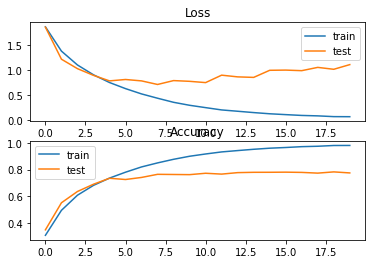

(10000, 32, 32, 3)
test accuracy: 10.0 %
test accuracy: 75.83 %
confusion_matrix:
 [[768  11  98   9  17   4  13  10  41  29]
 [ 12 851  15   7   3   5   8   2  32  65]
 [ 37   4 753  33  56  27  66  17   5   2]
 [ 19   3 121 555  53 100  90  35  13  11]
 [ 10   2  82  41 742  27  54  36   5   1]
 [ 10   0 121 167  35 577  39  39   8   4]
 [  4   2  42  32  21  17 868   4   5   5]
 [  8   3  50  33  65  35   5 789   1  11]
 [ 56   6  25   6   9   5  12   3 852  26]
 [ 30  59  21   9   3   4  16  11  19 828]]
class  0  accuracy  airplane  : 80.50314465408806 %
class  1  accuracy  automobile  : 90.43570669500531 %
class  2  accuracy  bird  : 56.701807228915655 %
class  3  accuracy  cat  : 62.21973094170403 %
class  4  accuracy  deer  : 73.90438247011953 %
class  5  accuracy  dog  : 72.03495630461923 %
class  6  accuracy  frog  : 74.12467976088813 %
class  7  accuracy  horse  : 83.40380549682875 %
class  8  accuracy  ship  : 86.85015290519877 %
class  9  accuracy  truck  : 84.317718940936

In [115]:
#brute model
print("/nbrute model/n")
brute_model = brute_vgg16()
test_brute_model_on_gray_scale_test_images(brute_model)
class_accuracy_brute_model = class_wise_accuracy(brute_model)
bias_metrics(class_accuracy_brute_model,brute_model)




In [40]:
def create_results(brute_model):
    
    (x_train, y_train_without_one_hot), (x_test, y_test_without_one_hot) = tf.keras.datasets.cifar10.load_data()

    y_train = to_categorical(y_train_without_one_hot)
    y_test = to_categorical(y_test_without_one_hot)
    
    y_pred_test = brute_model.predict(x_test)
    prediction_test = np.argmax(y_pred_test,axis=1)
    
    df = pd.DataFrame(np.hstack((y_test_without_one_hot,prediction_test.reshape(len(prediction_test),1))),columns=['y_test','y_test_pred'],index=None)
    print(df.head())
    df.to_csv("y_test_prediction_test.csv",index=False)
    
    correct_idxes = []
    incorrect_idxes = []
    
    for i in range(len(prediction_test)):
        if y_test_without_one_hot[i] == prediction_test[i]:
            correct_idxes.append(i)
            
        elif y_test_without_one_hot[i] != prediction_test[i]:
            incorrect_idxes.append(i)
            

    
    cv2.imwrite("correct"+str(int(y_test_without_one_hot[correct_idxes[0]][0]))+".jpg",x_test[correct_idxes[0]])
    cv2.imwrite("correct"+str(int(y_test_without_one_hot[correct_idxes[1]][0]))+".jpg",x_test[correct_idxes[1]])        
    cv2.imwrite("incorrect"+str(int(y_test_without_one_hot[incorrect_idxes[0]][0]))+".jpg",x_test[incorrect_idxes[0]])
    cv2.imwrite("incorrect"+str(int(y_test_without_one_hot[incorrect_idxes[1]][0]))+".jpg",x_test[incorrect_idxes[1]])



layer name: block5_conv3


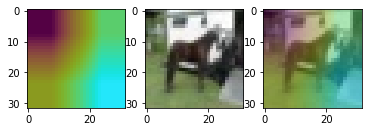

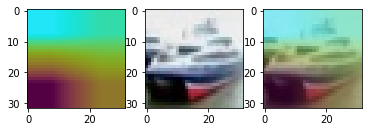

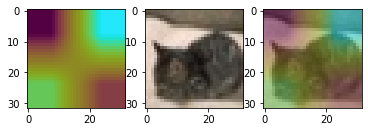

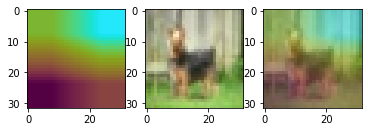

layer name: block4_conv2


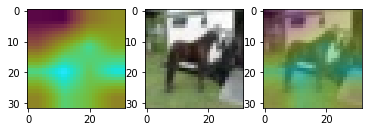

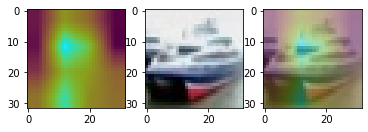

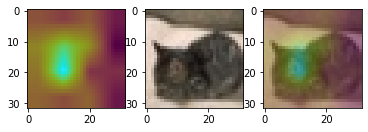

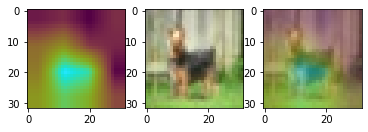

In [68]:
class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName

        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):

        for layer in reversed(self.model.layers):
            if len(layer.output_shape) == 4:
                return layer.name
            
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")


    def compute_heatmap(self, image, eps=1e-8):

        gradModel = Model(inputs=[self.model.inputs],outputs=[self.model.get_layer(self.layerName).output, self.model.output])

        with tf.GradientTape() as tape:

            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            
            loss = predictions[:, tf.argmax(predictions[0])]

        grads = tape.gradient(loss, convOutputs)

        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads

        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))

        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,colormap=cv2.COLORMAP_VIRIDIS):

        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)

        return (heatmap, output)

    
def make_gradCAM(img_path,brute_model,classified,layer_name="block5_conv3"):
    image = cv2.imread(img_path)
    image = cv2.resize(image, (32, 32))
    image = np.expand_dims(image, axis=0)

    preds = brute_model.predict(image) 
    i = np.argmax(preds[0])


    icam = GradCAM(brute_model, i,layer_name) 
    heatmap = icam.compute_heatmap(image)
    heatmap = cv2.resize(heatmap, (32, 32))

    image = cv2.imread(img_path)
    image = cv2.resize(image, (32, 32))

    (heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)


    fig, ax = plt.subplots(1, 3)

    ax[0].imshow(heatmap)
    ax[1].imshow(image)
    ax[2].imshow(output)
    plt.savefig("GradCAM_"+ str(classified)+str(img_path[-5])+".jpg")
    plt.show()
    plt.close()

layer_names = ["block5_conv3","block4_conv2"]
for l in layer_names:
    print("layer name:",l)
    
    make_gradCAM("/home/euclid/Desktop/Chiranjeev/DAI/Assignment_1_Q2/correct_actual7pred7.jpg",brute_model,classified="correct",layer_name=l)
    make_gradCAM("/home/euclid/Desktop/Chiranjeev/DAI/Assignment_1_Q2/correct_actual8pred8.jpg",brute_model,classified="correct",layer_name=l)
    make_gradCAM("/home/euclid/Desktop/Chiranjeev/DAI/Assignment_1_Q2/incorrect_actual3pred0.jpg",brute_model,classified="incorrect",layer_name=l)
    make_gradCAM("/home/euclid/Desktop/Chiranjeev/DAI/Assignment_1_Q2/incorrect_actual5pred4.jpg",brute_model,classified="incorrect",layer_name =l)

layer name: block5_conv3


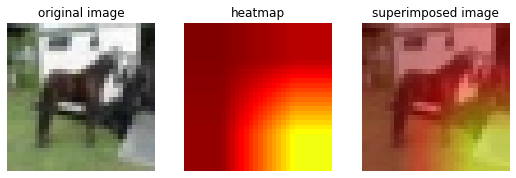

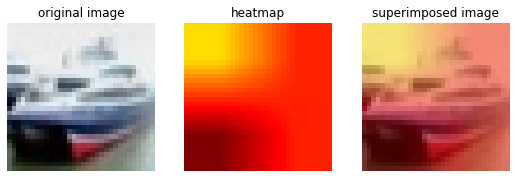

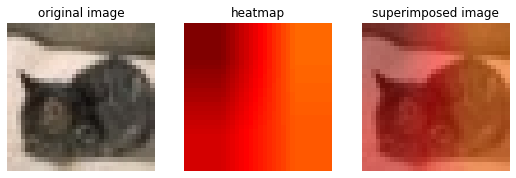

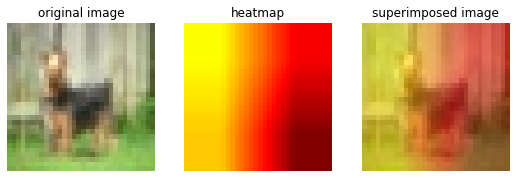

layer name: block4_conv2


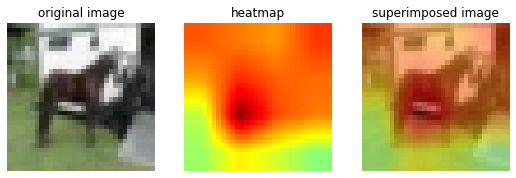

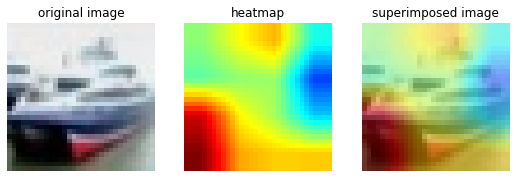

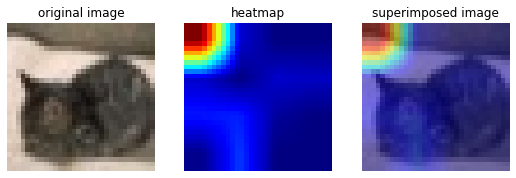

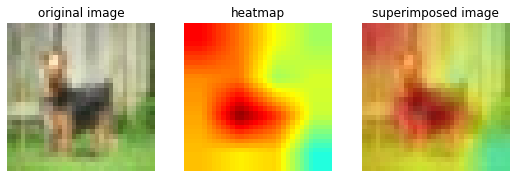

In [161]:
def grad_cam_pp(model, img,layer_name="block5_conv3", label_name=None,category_id=None):

    img_tensor = np.expand_dims(img, axis=0)

    conv_layer = model.get_layer(layer_name)
    heatmap_model = Model([model.inputs], [conv_layer.output, model.output])

    with tf.GradientTape() as gtape1:
        with tf.GradientTape() as gtape2:
            with tf.GradientTape() as gtape3:
                conv_output, predictions = heatmap_model(img_tensor)
                if category_id==None:
                    category_id = np.argmax(predictions[0])
                output = predictions[:, category_id]
                conv_first_grad = gtape3.gradient(output, conv_output)
            conv_second_grad = gtape2.gradient(conv_first_grad, conv_output)
        conv_third_grad = gtape1.gradient(conv_second_grad, conv_output)

    global_sum = np.sum(conv_output, axis=(0, 1, 2))

    alpha_num = conv_second_grad[0]
    alpha_denom = conv_second_grad[0]*2.0 + conv_third_grad[0]*global_sum
    alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, 1e-10)
    
    alphas = alpha_num/alpha_denom
    alpha_normalization_constant = np.sum(alphas, axis=(0,1))
    alphas /= alpha_normalization_constant

    weights = np.maximum(conv_first_grad[0], 0.0)

    deep_linearization_weights = np.sum(weights*alphas, axis=(0,1))
    grad_CAM_map = np.sum(deep_linearization_weights*conv_output[0], axis=2)

    heatmap = np.maximum(grad_CAM_map, 0)
    max_heat = np.max(heatmap)
    if max_heat == 0:
        max_heat = 1e-10
    heatmap /= max_heat

    return heatmap


    
def superimpose(img, cam):
    
    heatmap = cv2.resize(cam, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap,cv2.COLOR_BGR2RGB)
    superimposed_img = heatmap * .5 + img * .5
    superimposed_img = np.minimum(superimposed_img, 255.0).astype(np.uint8)  



    return img, heatmap, superimposed_img

def plot(img,cam):
    img = cv2.resize(img, (32, 32))
    img, heatmap, superimposed_img = superimpose(img, cam)

    fig, axs = plt.subplots(ncols=3, figsize=(9, 4))

    axs[0].imshow(img)
    axs[0].set_title('original image')
    axs[0].axis('off')

    axs[1].imshow(heatmap)
    axs[1].set_title('heatmap')
    axs[1].axis('off')

    axs[2].imshow(superimposed_img)
    axs[2].set_title('superimposed image')
    axs[2].axis('off')

    plt.show()
    plt.close()
    
layer_names = ["block5_conv3","block4_conv2"]
for l in layer_names:
    print("layer name:",l)

    img_path1 = "/home/euclid/Desktop/Chiranjeev/DAI/Assignment_1_Q2/correct_actual7pred7.jpg"
    img_path2 = "/home/euclid/Desktop/Chiranjeev/DAI/Assignment_1_Q2/correct_actual8pred8.jpg"
    img_path3 = "/home/euclid/Desktop/Chiranjeev/DAI/Assignment_1_Q2/incorrect_actual3pred0.jpg"
    img_path4 = "/home/euclid/Desktop/Chiranjeev/DAI/Assignment_1_Q2/incorrect_actual5pred4.jpg"
    
    img1 = cv2.imread(img_path1)
    cam1 = grad_cam_pp(brute_model, img1,layer_name=l, label_name=labels,category_id=int(img_path1[-5]))
    plot(img1,cam1)
    
    
    img2 = cv2.imread(img_path2)
    cam2 = grad_cam_pp(brute_model, img2,layer_name=l, label_name=labels,category_id=int(img_path2[-5]))
    plot(img2,cam2)
    
    img3 = cv2.imread(img_path3)
    cam3 = grad_cam_pp(brute_model, img3,layer_name=l, label_name=labels,category_id=int(img_path3[-5]))
    plot(img3,cam3)
    
    img4 = cv2.imread(img_path4)
    cam4 = grad_cam_pp(brute_model, img4,layer_name=l, label_name=labels,category_id=int(img_path4[-5]))
    plot(img4,cam4)
    

In [162]:
def preprocessed_data_model():

    (x_train, y_train_without_one_hot), (x_test, y_test_without_one_hot) = tf.keras.datasets.cifar10.load_data()

    y_train = to_categorical(y_train_without_one_hot)
    y_test = to_categorical(y_test_without_one_hot)

    x_train,x_valid,y_train,y_valid = train_test_split(x_train,y_train,test_size = 0.2,shuffle=True,random_state = 42)

    print(x_train.shape)
    print(y_train.shape)
    print(x_test.shape)
    print(y_test.shape)
    print(x_valid.shape)
    print(y_valid.shape)
    

    train_datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,horizontal_flip=True, rotation_range=20) 
    train_datagen.fit(x_train)
    valid_datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True)
    valid_datagen.fit(x_valid) 
    test_datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True)
    test_datagen.fit(x_test)

    train_generator = train_datagen.flow(x_train, y_train, batch_size=16)
    valid_generator = valid_datagen.flow(x_valid, y_valid, batch_size=16)
    test_generator = test_datagen.flow(x_test, y_test, batch_size=16)


    vgg16 = VGG16(include_top=True,weights = None, input_shape = (32,32,3))

    out = Dense(10,activation='softmax',name = 'fc3')(vgg16.get_layer('fc2').output)

    preprocessed_model = Model(inputs = vgg16.input,outputs = out)


    epochs = 20
    learning_rate = 0.1
    decay_rate = learning_rate/epochs
    sgd = tf.keras.optimizers.SGD(lr=learning_rate, decay=decay_rate, momentum=0.9, nesterov=False)
    preprocessed_model.compile(loss = 'categorical_crossentropy',optimizer = 'sgd',metrics=['accuracy'])
    

    
    
    history = preprocessed_model.fit(x=train_generator,steps_per_epoch=len(train_generator),validation_data=valid_generator,validation_steps=len(valid_generator),epochs=epochs)

  # model evaluation
    _, test_accuracy = preprocessed_model.evaluate_generator(test_generator, steps=len(test_generator),verbose=0)
    print("test accuracy:",test_accuracy)
      
        
    train_datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,horizontal_flip=True, rotation_range=20) 
    train_datagen.fit(x_train)
    test_datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True)
    test_datagen.fit(x_test)

    train_generator = train_datagen.flow(x_train, y_train, batch_size=16)
    test_generator = test_datagen.flow(x_test, y_test, batch_size=16)
    
    _, train_accuracy = preprocessed_model.evaluate_generator(train_generator, steps=len(train_generator),verbose=0)
    print("train accuracy:",train_accuracy)
    
    y_pred_test = preprocessed_model.predict(x=test_generator, steps=len(test_generator))
    predictions_test = np.argmax(y_pred_test, axis=1)
    
    preprocessed_model.save("vgg16_cifar10_preprocessed_rot_new")

    
    plt.subplot(211)
    plt.title('Loss')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.savefig("loss_preprocess_flip_rot.png")
    plt.close()

    plt.subplot(212)
    plt.title('Accuracy')
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='test')
    plt.legend()
    plt.savefig("accuracy_preprocess_flip_rot.png")
    plt.close()
    return preprocessed_model



In [38]:
def preprocess_helper():
    
    (x_train, y_train_without_one_hot), (x_test, y_test_without_one_hot) = tf.keras.datasets.cifar10.load_data()
    y_test = to_categorical(y_test_without_one_hot)


    test_datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True)
    test_datagen.fit(x_test)
    test_generator = test_datagen.flow(x_test, y_test, batch_size=16)

    x_test_preprocessed = []
    y_test_preprocessed = []


    for i in range(len(test_generator)):
        for img in test_generator[i][0]:
            x_test_preprocessed.append(img)
        for lb in test_generator[i][1]:
            y_test_preprocessed.append(lb)


    x_test_preprocessed = np.array(x_test_preprocessed)
    y_test_preprocessed = np.array(y_test_preprocessed)
    
    return x_test_preprocessed,y_test_preprocessed

def class_wise_accuracy_preprocess(models,x_test,y_test):
    
    labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


    y_test_without_one_hot = np.argmax(y_test,axis=1)

    y_pred_test = models.predict(x_test)
    prediction_test = np.argmax(y_pred_test,axis=1)
    print("test accuracy:",accuracy_score(np.argmax(y_test,axis=1),prediction_test)*100,"%")

    confus_matrix = confusion_matrix(np.argmax(y_test,axis=1),prediction_test)
    print("confusion_matrix:\n",confus_matrix)
    class_accuracy = []
    class_TP = []

    for i in range(confus_matrix.shape[0]):
        for j in range(confus_matrix.shape[1]):
              if i == j:
                TP = confus_matrix[i][j]
                class_TP.append(TP)

    for k in range(confus_matrix.shape[1]):
        ca = (class_TP[k] / confus_matrix[:,k].sum())*100
        class_accuracy.append(ca)
        print("class ",k," accuracy ",labels[k]," :",ca,"%")    

    class_accuracy = np.array(class_accuracy)

    return class_accuracy



def bias_metrics_preprocess(class_accuracy,models,x_test,y_test):
    
    dob = np.std(class_accuracy)
    print("Degree of Bias:",dob)
    
    y_test_without_one_hot = np.argmax(y_test,axis=1)
    y_pred_test = models.predict(x_test)
    prediction_test = np.argmax(y_pred_test,axis=1)
    
    from sklearn.metrics import confusion_matrix
    confuse_matrix = confusion_matrix(y_test_without_one_hot, prediction_test)
    print("confusion_matrix:\n",confuse_matrix)
    
    FP = confuse_matrix.sum(axis=0) - np.diag(confuse_matrix)
    FN = confuse_matrix.sum(axis=1) - np.diag(confuse_matrix)
    TP = np.diag(confuse_matrix)
    TN = confuse_matrix.sum() - (FP+FN+TP)
    
    FP=FP.astype(float)
    TP=TP.astype(float)
    FN=FN.astype(float)
    TN=TN.astype(float)
    
    FNR = FN/(TP+FN)
    
    FPR = FP/(TN+FN)
    
    print("FPR:",FPR)
    print("FNR:",FNR)
    
    AFR = ((FPR.sum()/10)+(FNR.sum()/10))/2
    
    print("AFR:",AFR)
    


def create_results_preprocess(models,x_test,y_test):
    
    y_test_without_one_hot = np.argmax(y_test,axis=1)
    print(y_test.shape)
    print(x_test.shape)
    
    y_pred_test = models.predict(x_test)
    prediction_test = np.argmax(y_pred_test,axis=1)
    
    df = pd.DataFrame(np.hstack((y_test_without_one_hot.reshape(len(y_test_without_one_hot),1),prediction_test.reshape(len(prediction_test),1))),columns=['y_test','y_test_pred'],index=None)
    print(df.head())
    df.to_csv("y_test_prediction_test.csv",index=False)
    
    correct_idxes = []
    incorrect_idxes = []
    
    for i in range(len(prediction_test)):
        if y_test_without_one_hot[i] == prediction_test[i]:
            correct_idxes.append(i)
            
        elif y_test_without_one_hot[i] != prediction_test[i]:
            incorrect_idxes.append(i)
    

In [39]:
#preporocess model

print("\npreporocess model\n")
preprocessed_model = preprocessed_data_model()
x_test_preprocessed,y_test_preprocessed = preprocess_helper()
preprocessed_model1 = tf.keras.models.load_model("/home/euclid/Desktop/Chiranjeev/DAI/vgg16_cifar10_preprocessed_rot_new")
class_accuracy_preprocessed_model1 = class_wise_accuracy_preprocess(preprocessed_model1, x_test_preprocessed,y_test_preprocessed)
bias_metrics_preprocess(class_accuracy_preprocessed_model1,preprocessed_model1, x_test_preprocessed,y_test_preprocessed)
create_results_preprocess(preprocessed_model1, x_test_preprocessed,y_test_preprocessed)



preporocess model

test accuracy: 79.74 %
confusion_matrix:
 [[853  26  16  14   9   1   4   4  33  40]
 [  5 969   0   1   1   0   1   0   2  21]
 [ 95  13 673  29  51  37  84   8   4   6]
 [ 25  18  44 573  56 129 109  15   9  22]
 [ 24   1  49  31 792   9  77  14   0   3]
 [  9  11  25 119  44 709  38  33   2  10]
 [  4   9  15  21  11   4 930   0   2   4]
 [ 19   5  17  35  80  29   7 783   0  25]
 [ 70  61   0  10   5   1   8   0 803  42]
 [ 11  80   0   5   4   0   6   3   2 889]]
class  0  accuracy  airplane  : 76.50224215246637 %
class  1  accuracy  automobile  : 81.22380553227158 %
class  2  accuracy  bird  : 80.21454112038141 %
class  3  accuracy  cat  : 68.37708830548927 %
class  4  accuracy  deer  : 75.21367521367522 %
class  5  accuracy  dog  : 77.14907508161045 %
class  6  accuracy  frog  : 73.57594936708861 %
class  7  accuracy  horse  : 91.04651162790698 %
class  8  accuracy  ship  : 93.69894982497082 %
class  9  accuracy  truck  : 83.70998116760828 %
Degree of Bias: 7

In [118]:
def method_model():

    (x_train, y_train_without_one_hot), (x_test, y_test_without_one_hot) = tf.keras.datasets.cifar10.load_data()

    y_train = to_categorical(y_train_without_one_hot)
    y_test = to_categorical(y_test_without_one_hot)

    x_train,x_valid,y_train,y_valid = train_test_split(x_train,y_train,test_size = 0.2,shuffle=True,random_state = 42)

    print(x_train.shape)
    print(y_train.shape)
    print(x_test.shape)
    print(y_test.shape)
    print(x_valid.shape)
    print(y_valid.shape)


    vgg16 = VGG16(include_top=True,weights = None, input_shape = (32,32,3))

    out = Dense(10,activation='softmax',name = 'fc3')(vgg16.get_layer('fc2').output)

    kl_model = Model(inputs = vgg16.input,outputs = out)


    epochs = 20
    learning_rate = 0.01
    decay_rate = learning_rate/epochs
    sgd = tf.keras.optimizers.SGD(lr=learning_rate, decay=decay_rate, momentum=0.9, nesterov=False)
    kl_model.compile(loss = 'kullback_leibler_divergence',optimizer = 'sgd',metrics=['accuracy']) #tf.keras.optimizers.Adam(learning_rate=0.0001)
    history = kl_model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=epochs, batch_size=16)


    kl_model.save("vgg16_cifar10_method")

    y_pred_train = kl_model.predict(x_train)
    predictions_train = np.argmax(y_pred_train,axis=1)
    print("training accuracy:",accuracy_score(np.argmax(y_train,axis=1),predictions_train))

    y_pred_test = kl_model.predict(x_test)
    prediction_test = np.argmax(y_pred_test,axis=1)
    print("test accuracy:",accuracy_score(np.argmax(y_test,axis=1),prediction_test))

    plt.subplot(211)
    plt.title('Loss')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()

    plt.subplot(212)
    plt.title('Accuracy')
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='test')
    plt.legend()
    plt.show()

    return kl_model


/nmethod model/n
(40000, 32, 32, 3)
(40000, 10)
(10000, 32, 32, 3)
(10000, 10)
(10000, 32, 32, 3)
(10000, 10)


/home/euclid/.local/lib/python3.6/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/20
2500/2500 [==============================] - 509s 203ms/step - loss: 1.8786 - accuracy: 0.3044 - val_loss: 1.6369 - val_accuracy: 0.3939
Epoch 2/20
2500/2500 [==============================] - 505s 202ms/step - loss: 1.4153 - accuracy: 0.4857 - val_loss: 1.2714 - val_accuracy: 0.5436
Epoch 3/20
2500/2500 [==============================] - 515s 206ms/step - loss: 1.1290 - accuracy: 0.6004 - val_loss: 0.9973 - val_accuracy: 0.6597
Epoch 4/20
2500/2500 [==============================] - 476s 190ms/step - loss: 0.9274 - accuracy: 0.6750 - val_loss: 0.8627 - val_accuracy: 0.6969
Epoch 5/20
2500/2500 [==============================] - 454s 181ms/step - loss: 0.7710 - accuracy: 0.7320 - val_loss: 0.8146 - val_accuracy: 0.7191
Epoch 6/20
2500/2500 [==============================] - 450s 180ms/step - loss: 0.6429 - accuracy: 0.7756 - val_loss: 0.9103 - val_accuracy: 0.7208
Epoch 7/20
2500/2500 [==============================] - 449s 180ms/step - loss: 0.5324 - accuracy: 0.8148 - val_

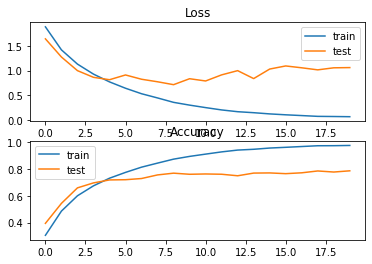

test accuracy: 77.69 %
confusion_matrix:
 [[812  11  33  24  15   3   8   7  49  38]
 [  9 873   4   5   2   5  11   3  31  57]
 [ 60   4 671  51  60  54  68  21   7   4]
 [ 28   3  69 562  56 143  82  32   7  18]
 [ 16   3  43  50 775  24  59  22   6   2]
 [  9   3  56 117  46 705  25  32   2   5]
 [  7   3  36  32  24   9 876   5   5   3]
 [ 13   1  38  29  79  45   5 783   1   6]
 [ 49  14  13  14   5   6   8   0 862  29]
 [ 24  58   5  17   4   5  12  10  15 850]]
class  0  accuracy  airplane  : 79.06523855890944 %
class  1  accuracy  automobile  : 89.72250770811921 %
class  2  accuracy  bird  : 69.31818181818183 %
class  3  accuracy  cat  : 62.375138734739174 %
class  4  accuracy  deer  : 72.70168855534709 %
class  5  accuracy  dog  : 70.57057057057057 %
class  6  accuracy  frog  : 75.90987868284229 %
class  7  accuracy  horse  : 85.57377049180329 %
class  8  accuracy  ship  : 87.51269035532995 %
class  9  accuracy  truck  : 83.99209486166008 %
Degree of Bias: 8.534612909248736
co

In [119]:
#method model

print("/nmethod model/n")
kl_model = method_model()
class_accuracy_kl_model = class_wise_accuracy(kl_model)
bias_metrics(class_accuracy_kl_model,kl_model)
create_results(kl_model)

In [120]:
print("\npreprocessed model\n")
class_accuracy_preprocessed = class_wise_accuracy(preprocessed_model)
print("each class accuracies preprocessed",class_accuracy_preprocessed)
bias_metrics(class_accuracy_preprocessed,preprocessed_model)

print("\nmethod model\n")

class_accuracy_method = class_wise_accuracy(kl_model)
print("each class accuracies mehtod",class_accuracy_method)
bias_metrics(class_accuracy_method,kl_model)



preprocessed model

test accuracy: 45.410000000000004 %
confusion_matrix:
 [[691 102   1   5   0   5   0  26   4 166]
 [  4 929   0   0   0   0   0   4   0  63]
 [261 171  88  57   2 116   2 136   5 162]
 [ 37 266   5 193   0  99   3 162   1 234]
 [ 83 213   3  39  43  70   1 364   0 184]
 [ 17 155   0  68   0 413   0 234   0 113]
 [ 17 454   0  45   0  26  98  53   4 303]
 [ 12  63   0   2   0  20   0 807   0  96]
 [134 271   0   1   0   0   0   6 399 189]
 [  4 107   0   0   0   0   0   7   2 880]]
class  0  accuracy  airplane  : 54.84126984126985 %
class  1  accuracy  automobile  : 34.01684364701574 %
class  2  accuracy  bird  : 90.72164948453609 %
class  3  accuracy  cat  : 47.073170731707314 %
class  4  accuracy  deer  : 95.55555555555556 %
class  5  accuracy  dog  : 55.140186915887845 %
class  6  accuracy  frog  : 94.23076923076923 %
class  7  accuracy  horse  : 44.85825458588105 %
class  8  accuracy  ship  : 96.14457831325302 %
class  9  accuracy  truck  : 36.82008368200837 %
e

In [187]:
def check_bias_by_counting(filename):
    df = pd.read_csv(filename)
    
    #gender 0 (g1) male
    
    race1_correct_g1 = 0
    race2_correct_g1 = 0
    race3_correct_g1 = 0
    race4_correct_g1 = 0
    age_0_28_correct_g1 = 0
    age_29_56_correct_g1 = 0
    age_57_84_correct_g1 = 0
    age_85_116_correct_g1 = 0
    
    
    race1_incorrect_g1 = 0
    race2_incorrect_g1 = 0
    race3_incorrect_g1 = 0
    race4_incorrect_g1 = 0
    age_0_28_incorrect_g1 = 0
    age_29_56_incorrect_g1 = 0
    age_57_84_incorrect_g1 = 0
    age_85_116_incorrect_g1 = 0
    
    #gender 1 (g2) female
    
    race1_correct_g2 = 0
    race2_correct_g2 = 0
    race3_correct_g2 = 0
    race4_correct_g2 = 0
    age_0_28_correct_g2 = 0
    age_29_56_correct_g2 = 0
    age_57_84_correct_g2 = 0
    age_85_116_correct_g2 = 0
    
    
    race1_incorrect_g2 = 0
    race2_incorrect_g2 = 0
    race3_incorrect_g2 = 0
    race4_incorrect_g2 = 0
    age_0_28_incorrect_g2 = 0
    age_29_56_incorrect_g2 = 0
    age_57_84_incorrect_g2 = 0
    age_85_116_incorrect_g2 = 0
    
    
    df_np = df.iloc[:,:].values
    
    for i in range(len(df_np)):
     
        #correct predictions
        if df_np[i][2] == df_np[i][4]:
            
            #male
            if df_np[i][2] == 0:
            
                # age groups
                if df_np[i][1] == 0:
                    age_0_28_correct_g1 += 1

                elif df_np[i][1] == 1:
                    age_29_56_correct_g1+=1

                elif df_np[i][1] == 2:
                    age_57_84_correct_g1 += 1

                elif df_np[i][1] == 3:
                    age_85_116_correct_g1 += 1

                #race groups

                if df_np[i][3] == 0:
                    race1_correct_g1 += 1

                elif df_np[i][3] == 1:
                    race2_correct_g1+=1

                elif df_np[i][3] == 2:
                    race3_correct_g1 += 1

                elif df_np[i][3] == 3:
                    race4_correct_g1 += 1
            
            #female
            elif df_np[i][2] == 1:
                
                # age groups
                
                if df_np[i][1] == 0:
                    age_0_28_correct_g2 += 1

                elif df_np[i][1] == 1:
                    age_29_56_correct_g2+=1

                elif df_np[i][1] == 2:
                    age_57_84_correct_g2 += 1

                elif df_np[i][1] == 3:
                    age_85_116_correct_g2 += 1

                #race groups

                if df_np[i][3] == 0:
                    race1_correct_g2 += 1

                elif df_np[i][3] == 1:
                    race2_correct_g2+=1

                elif df_np[i][3] == 2:
                    race3_correct_g2 += 1

                elif df_np[i][3] == 3:
                    race4_correct_g2 += 1
                
                
                
        elif df_np[i][2] != df_np[i][4]:
            
            #male
            if df_np[i][2] == 0:

                    # age groups
                    if df_np[i][1] == 0:
                        age_0_28_incorrect_g1 += 1

                    elif df_np[i][1] == 1:
                        age_29_56_incorrect_g1+=1

                    elif df_np[i][1] == 2:
                        age_57_84_incorrect_g1 += 1

                    elif df_np[i][1] == 3:
                        age_85_116_incorrect_g1 += 1

                    #race groups

                    if df_np[i][3] == 0:
                        race1_incorrect_g1 += 1

                    elif df_np[i][3] == 1:
                        race2_incorrect_g1+=1

                    elif df_np[i][3] == 2:
                        race3_incorrect_g1 += 1

                    elif df_np[i][3] == 3:
                        race4_incorrect_g1 += 1
                        
            #female
            elif df_np[i][2] == 1:
                

                    # age groups
                    if df_np[i][1] == 0:
                        age_0_28_incorrect_g2 += 1

                    elif df_np[i][1] == 1:
                        age_29_56_incorrect_g2+=1

                    elif df_np[i][1] == 2:
                        age_57_84_incorrect_g2 += 1

                    elif df_np[i][1] == 3:
                        age_85_116_incorrect_g2 += 1

                    #race groups

                    if df_np[i][3] == 0:
                        race1_incorrect_g2 += 1

                    elif df_np[i][3] == 1:
                        race2_incorrect_g2+=1

                    elif df_np[i][3] == 2:
                        race3_incorrect_g2 += 1

                    elif df_np[i][3] == 3:
                        race4_incorrect_g2 += 1
                
                

    


    
    print("DoB")
    
    #gender 1
    race1_accuracy_g1 = (race1_correct_g1/(race1_correct_g1+race1_incorrect_g1))*100
    race2_accuracy_g1 = (race2_correct_g1/(race2_correct_g1+race2_incorrect_g1))*100
    race3_accuracy_g1 = (race3_correct_g1/(race3_correct_g1+race3_incorrect_g1))*100
    race4_accuracy_g1 = (race4_correct_g1/(race4_correct_g1+race4_incorrect_g1))*100
    
    print("race1_accuracy_g1:",race1_accuracy_g1)
    print("race2_accuracy_g1:",race2_accuracy_g1)
    print("race3_accuracy_g1:",race3_accuracy_g1)
    print("race4_accuracy_g1:",race4_accuracy_g1)
    
    
    age_0_28_accuracy_g1 = (age_0_28_correct_g1/(age_0_28_correct_g1+age_0_28_incorrect_g1))*100 
    age_29_56_accuracy_g1 = (age_29_56_correct_g1/(age_29_56_correct_g1+age_29_56_incorrect_g1))*100 
    age_57_84_accuracy_g1 = (age_57_84_correct_g1/(age_57_84_correct_g1+age_57_84_incorrect_g1))*100 
    age_85_116_accuracy_g1 = (age_85_116_correct_g1/(age_85_116_correct_g1+age_85_116_incorrect_g1))*100 
    
    print("age_0_28_accuracy_g1:",age_0_28_accuracy_g1)
    print("age_29_56_accuracy_g1:",age_29_56_accuracy_g1)
    print("age_57_84_accuracy_g1:",age_57_84_accuracy_g1)
    print("age_85_116_accuracy_g1:",age_85_116_accuracy_g1)
    
    
    #gender2
    race1_accuracy_g2 = (race1_correct_g2/(race1_correct_g2+race1_incorrect_g2))*100
    race2_accuracy_g2 = (race2_correct_g2/(race2_correct_g2+race2_incorrect_g2))*100
    race3_accuracy_g2 = (race3_correct_g2/(race3_correct_g2+race3_incorrect_g2))*100
    race4_accuracy_g2 = (race4_correct_g2/(race4_correct_g2+race4_incorrect_g2))*100
    
        
    print("race1_accuracy_g2:",race1_accuracy_g2)
    print("race2_accuracy_g2:",race2_accuracy_g2)
    print("race3_accuracy_g2:",race3_accuracy_g2)
    print("race4_accuracy_g2:",race4_accuracy_g2)
    
    age_0_28_accuracy_g2 = (age_0_28_correct_g2/(age_0_28_correct_g2+age_0_28_incorrect_g2))*100 
    age_29_56_accuracy_g2 = (age_29_56_correct_g2/(age_29_56_correct_g2+age_29_56_incorrect_g2))*100 
    age_57_84_accuracy_g2 = (age_57_84_correct_g2/(age_57_84_correct_g2+age_57_84_incorrect_g2))*100 
    age_85_116_accuracy_g2 = (age_85_116_correct_g2/(age_85_116_correct_g2+age_85_116_incorrect_g2))*100 
    
    print("age_0_28_accuracy_g2:",age_0_28_accuracy_g2)
    print("age_29_56_accuracy_g2:",age_29_56_accuracy_g2)
    print("age_57_84_accuracy_g2:",age_57_84_accuracy_g2)
    print("age_85_116_accuracy_g2:",age_85_116_accuracy_g2)
    
    
    
    print("DoB across race")
    
    dob_across_race1 = np.std(np.array([race1_accuracy_g1,race1_accuracy_g2]))
    dob_across_race2 = np.std(np.array([race2_accuracy_g1,race2_accuracy_g2]))
    dob_across_race3 = np.std(np.array([race3_accuracy_g1,race3_accuracy_g2]))
    dob_across_race4 = np.std(np.array([race4_accuracy_g1,race4_accuracy_g2]))    
    
    
    dob_across_race_overall = (dob_across_race1+dob_across_race2+dob_across_race3+dob_across_race4)/4
    dob_across_race_overall
    print("dob_across_race_overall:",dob_across_race_overall)
    
    
    
    print("DoB across age")
    
    dob_across_age_0_28 = np.std(np.array([age_0_28_accuracy_g1,age_0_28_accuracy_g2]))
    dob_across_age_29_56 = np.std(np.array([age_29_56_accuracy_g1,age_29_56_accuracy_g2]))
    dob_across_age_57_84 = np.std(np.array([age_57_84_accuracy_g1,age_57_84_accuracy_g2]))
    dob_across_age_85_116 = np.std(np.array([age_85_116_accuracy_g1,age_85_116_accuracy_g2]))
    
    dob_across_age_overall = (dob_across_age_0_28+dob_across_age_29_56+dob_across_age_57_84+dob_across_age_85_116)/4
    print("dob_across_age_overall:",dob_across_age_overall)
    
    return dob_across_race1,dob_across_race2,dob_across_race3,dob_across_race4,dob_across_age_0_28,dob_across_age_29_56,dob_across_age_57_84,dob_across_age_85_116,dob_across_race_overall,dob_across_age_overall

    
    

In [200]:
print("cross entropy loss")
filename1 = "/home/euclid/Desktop/Chiranjeev/DAI/Assignment_1_Q1/categorical_cross_entropy/test_gender_across_race_age_y_test_pred2_optimizer2_45.csv"
dob_across_race1,dob_across_race2,dob_across_race3,dob_across_race4,dob_across_age_0_28,dob_across_age_29_56,dob_across_age_57_84,dob_across_age_85_116,dob_across_race_overall,dob_across_age_overall = check_bias_by_counting(filename1) 

print("\nfocal loss")
filename2 = "/home/euclid/Desktop/Chiranjeev/DAI/Assignment_1_Q1/focal_loss/test_gender_across_race_age_y_test_pred2_optimizer2_45_focal_loss.csv"
dob_across_race1,dob_across_race2,dob_across_race3,dob_across_race4,dob_across_age_0_28,dob_across_age_29_56,dob_across_age_57_84,dob_across_age_85_116,dob_across_race_overall,dob_across_age_overall = check_bias_by_counting(filename2) 

print("\nLinearsvm")
filename3 = "/home/euclid/Desktop/Chiranjeev/DAI/Assignment_1_Q1/svm/test_gender_across_race_age_y_test_pred2_optimizer2_svm.csv"
dob_across_race1,dob_across_race2,dob_across_race3,dob_across_race4,dob_across_age_0_28,dob_across_age_29_56,dob_across_age_57_84,dob_across_age_85_116,dob_across_race_overall,dob_across_age_overall = check_bias_by_counting(filename3) 


cross entropy loss
DoB
race1_accuracy_g1: 87.36654804270462
race2_accuracy_g1: 88.96103896103897
race3_accuracy_g1: 77.24550898203593
race4_accuracy_g1: 90.88729016786571
age_0_28_accuracy_g1: 76.71497584541062
age_29_56_accuracy_g1: 93.59095193213949
age_57_84_accuracy_g1: 92.81914893617021
age_85_116_accuracy_g1: 72.72727272727273
race1_accuracy_g2: 82.48587570621469
race2_accuracy_g2: 82.7188940092166
race3_accuracy_g2: 81.88976377952756
race4_accuracy_g2: 84.98659517426273
age_0_28_accuracy_g2: 85.15684774292272
age_29_56_accuracy_g2: 87.33997155049786
age_57_84_accuracy_g2: 68.94736842105263
age_85_116_accuracy_g2: 38.297872340425535
DoB across race
dob_across_race_overall: 2.7084708849258643
DoB across age
dob_across_age_overall: 9.124254147639814

focal loss
DoB
race1_accuracy_g1: 85.4982206405694
race2_accuracy_g1: 90.04329004329004
race3_accuracy_g1: 78.74251497005989
race4_accuracy_g1: 89.44844124700239
age_0_28_accuracy_g1: 77.10144927536233
age_29_56_accuracy_g1: 92.5541941